In [116]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

Importing dataset

In [2]:
dataset_raw = pd.read_csv("dataset_183_adult.csv",header=0)
print(dataset_raw.head(10))

   age         workclass  fnlwgt  education  education-num  \
0    2         State-gov   77516  Bachelors             13   
1    3  Self-emp-not-inc   83311  Bachelors             13   
2    2           Private  215646    HS-grad              9   
3    3           Private  234721       11th              7   
4    1           Private  338409  Bachelors             13   
5    2           Private  284582    Masters             14   
6    3           Private  160187        9th              5   
7    3  Self-emp-not-inc  209642    HS-grad              9   
8    1           Private   45781    Masters             14   
9    2           Private  159449  Bachelors             13   

          marital-status         occupation   relationship   race     sex  \
0          Never-married       Adm-clerical  Not-in-family  White    Male   
1     Married-civ-spouse    Exec-managerial        Husband  White    Male   
2               Divorced  Handlers-cleaners  Not-in-family  White    Male   
3     Mar

Exploring unique values in dataset

In [3]:
for col in dataset_raw.columns:
    print("Column: " + col)
    print("Number of unique values: " + str(pd.unique(dataset_raw[col]).shape[0]))
    print(pd.unique(dataset_raw[col]))
    print("\n")

Column: age
Number of unique values: 5
[2 3 1 0 4]


Column: workclass
Number of unique values: 9
['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']


Column: fnlwgt
Number of unique values: 28523
[ 77516  83311 215646 ... 173449  89686 350977]


Column: education
Number of unique values: 16
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']


Column: education-num
Number of unique values: 16
[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]


Column: marital-status
Number of unique values: 7
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']


Column: occupation
Number of unique values: 15
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 

In [4]:
print("FnlWgt: Continuous data stats")
print("Min: " + str(dataset_raw['fnlwgt'].min()))
print("Max: " + str(dataset_raw['fnlwgt'].max()))
print("Mean: " + str(dataset_raw['fnlwgt'].mean()))
print("Variance: " + str(dataset_raw['fnlwgt'].var()))

FnlWgt: Continuous data stats
Min: 12285
Max: 1490400
Mean: 189664.13459727284
Variance: 11152210185.574848


Since the dataset has mostly categorical data we will need to factorize them. Age, capitalloss, capitalgain, hoursperweek and education-num are factorized so we don't need to touch them. Education and education-num have a 1-1 relationship where education num is the factorized version so we can remove that column.
On the other hand fnlwgt is a continuous number, so depending on the algorithm we are using we will need to normalize using either z-score or min-max

Factorizing the categorical data

In [5]:
factorized_all = dataset_raw.loc[:, dataset_raw.columns != 'education'].copy()
to_factorize = ['class','native-country', 'sex', 'race', 'relationship', 'occupation', 'marital-status', 'workclass']
stacked = factorized_all[to_factorize].stack()
factorized_all[to_factorize] = pd.Series(stacked.factorize()[0], index=stacked.index).unstack().rank(method='dense')

In [6]:
for col in factorized_all.columns:
    print("Column: " + col)
    print("Number of unique values: " + str(pd.unique(factorized_all[col]).shape[0]))
    print(pd.unique(factorized_all[col]))
    print("\n")

Column: age
Number of unique values: 5
[2 3 1 0 4]


Column: workclass
Number of unique values: 9
[1. 2. 3. 5. 6. 4. 7. 8. 9.]


Column: fnlwgt
Number of unique values: 28523
[ 77516  83311 215646 ... 173449  89686 350977]


Column: education-num
Number of unique values: 16
[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]


Column: marital-status
Number of unique values: 7
[1. 2. 3. 4. 5. 6. 7.]


Column: occupation
Number of unique values: 15
[ 1.  2.  3.  4.  5.  6.  8.  9. 10. 11. 12.  7. 13. 14. 15.]


Column: relationship
Number of unique values: 6
[1. 2. 3. 4. 5. 6.]


Column: race
Number of unique values: 5
[1. 2. 3. 4. 5.]


Column: sex
Number of unique values: 2
[1. 2.]


Column: capitalgain
Number of unique values: 5
[1 0 4 2 3]


Column: capitalloss
Number of unique values: 5
[0 3 1 2 4]


Column: hoursperweek
Number of unique values: 5
[2 0 3 4 1]


Column: native-country
Number of unique values: 42
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 

Now that the data is factorized we need to min max normalize all features

In [7]:
normal_min_max = factorized_all.copy().values
min_max_scaler = preprocessing.MinMaxScaler()
dataset_scaled = min_max_scaler.fit_transform(normal_min_max)
print(dataset_scaled.shape)
print(dataset_scaled[0:20,:])

(48842, 14)
[[0.5        0.         0.04413121 0.8        0.         0.
  0.         0.         0.         0.25       0.         0.5
  0.         0.        ]
 [0.75       0.125      0.04805174 0.8        0.16666667 0.07142857
  0.2        0.         0.         0.         0.         0.
  0.         0.        ]
 [0.5        0.25       0.13758131 0.53333333 0.33333333 0.14285714
  0.         0.         0.         0.         0.         0.5
  0.         0.        ]
 [0.75       0.25       0.15048626 0.4        0.16666667 0.14285714
  0.2        0.25       0.         0.         0.         0.5
  0.         0.        ]
 [0.25       0.25       0.22063507 0.8        0.16666667 0.21428571
  0.4        0.25       1.         0.         0.         0.5
  0.02439024 0.        ]
 [0.5        0.25       0.18421909 0.86666667 0.16666667 0.07142857
  0.4        0.         1.         0.         0.         0.5
  0.         0.        ]
 [0.75       0.25       0.10006123 0.26666667 0.5        0.28571429
  0. 

Now that the dataset has been factorized and normalized, we can build our models

Logistic Regression

In [76]:
def get_best_model_from_kf(model, k=10, threshold=.5):
    ideal = model
    kf = KFold(n_splits=k)
    i = 0
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    stats = {}
    stats['max_precision'] = -1
    stats['max_p_acc'] = -1
    stats['max_p_recall'] = -1
    stats['max_iteration'] = 0
    for train_index, test_index in kf.split(dataset_scaled):
    
        train, test = dataset_scaled[train_index], dataset_scaled[test_index]
        fitted = model.fit(train[:,0:12],train[:,13])
        predictions = fitted.predict_proba(test[:,0:12])
        # classed = (predictions[:,1] > threshold).astype()
        if threshold is not None:
            predictions[:,1] = (predictions[:,1] > threshold).astype(int)
        fpr, tpr, thresholds = roc_curve(test[:,13], predictions[:,1])
        # predictions = fitted.predict(test[:,0:12])
        c_matrix = confusion_matrix(test[:,13], predictions[:,1])
        tn, fp, fn, tp = c_matrix.ravel()
        precision = tp / (tp + fp)
        if (precision > stats['max_precision']):
            stats['max_precision'] = precision
            stats['max_iteration'] = i
            stats['max_p_recall'] = tp / (tp + fn)
            stats['max_p_acc'] = (tp + tn) / (tn + fp + fn + tp)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Maximum Precision = %.2f at fold %d' % (stats['max_precision'], stats['max_iteration']))
    plt.legend(loc="lower right")
    plt.show()
    for key in stats.keys():
        print(key + ": " + str(res1[key]))

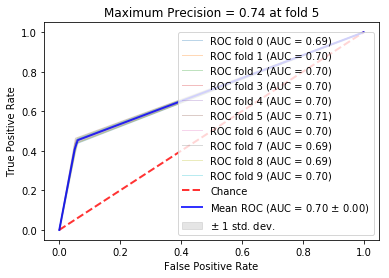

{'max_precision': 0.7359249329758714,
 'max_p_acc': 0.8296478296478297,
 'max_p_recall': 0.46368243243243246,
 'max_iteration': 5}

In [85]:
logreg_1 = LogisticRegression(solver="liblinear")
get_best_model_from_kf(logreg_1,k=10,threshold=.5)

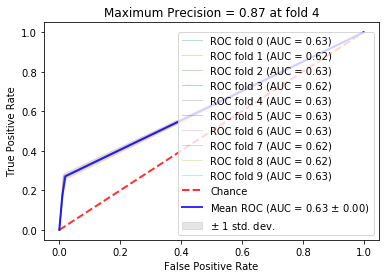

{'max_precision': 0.8729729729729729,
 'max_p_acc': 0.8128583128583129,
 'max_p_recall': 0.2714285714285714,
 'max_iteration': 4}

In [78]:
get_best_model_from_kf(logreg_1,k=10,threshold=.7)

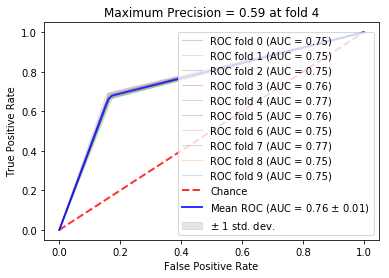

{'max_precision': 0.5873925501432665,
 'max_p_acc': 0.8063063063063063,
 'max_p_recall': 0.6890756302521008,
 'max_iteration': 4}

In [86]:
get_best_model_from_kf(logreg_1,k=10,threshold=.3)

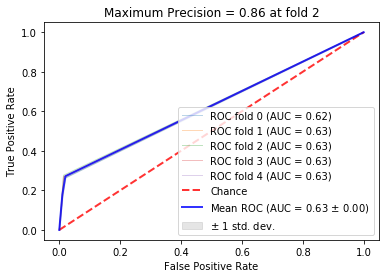

{'max_precision': 0.8642951251646904,
 'max_p_acc': 0.8135749385749386,
 'max_p_recall': 0.2763268744734625,
 'max_iteration': 2}

In [87]:
get_best_model_from_kf(logreg_1,k=5,threshold=.7)

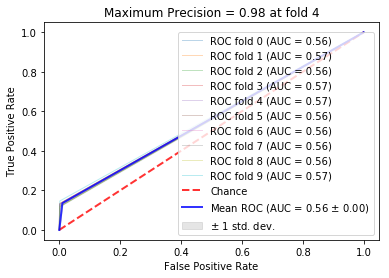

{'max_precision': 0.9751552795031055,
 'max_p_acc': 0.7876740376740377,
 'max_p_recall': 0.1319327731092437,
 'max_iteration': 4}

In [88]:
get_best_model_from_kf(logreg_1,k=10,threshold=.9)

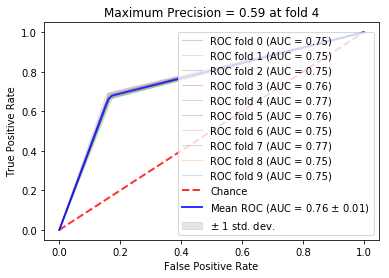

{'max_precision': 0.5873925501432665,
 'max_p_acc': 0.8063063063063063,
 'max_p_recall': 0.6890756302521008,
 'max_iteration': 4}

In [89]:
get_best_model_from_kf(logreg_1,k=10,threshold=.3)

kNN

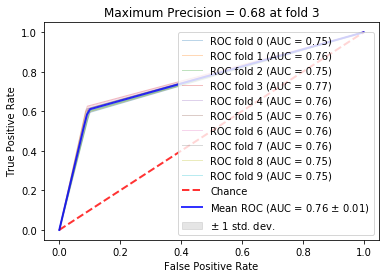

{'max_precision': 0.6812674743709226,
 'max_p_acc': 0.8404995904995906,
 'max_p_recall': 0.6258561643835616,
 'max_iteration': 3}

In [90]:
knn1 = KNeighborsClassifier(n_neighbors=5)
get_best_model_from_kf(knn1, k=10, threshold=.5)

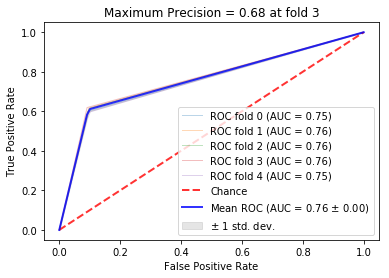

{'max_precision': 0.6812411847672779,
 'max_p_acc': 0.8392710892710893,
 'max_p_recall': 0.618966253737719,
 'max_iteration': 3}

In [91]:
get_best_model_from_kf(knn1, k=5, threshold=.5)

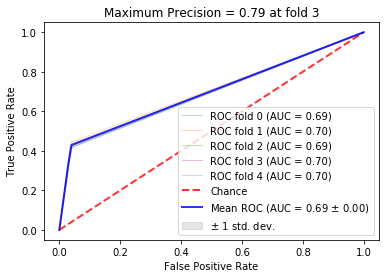

{'max_precision': 0.7905138339920948,
 'max_p_acc': 0.8355855855855856,
 'max_p_recall': 0.42716787697565145,
 'max_iteration': 3}

In [92]:
get_best_model_from_kf(knn1, k=5, threshold=.7)

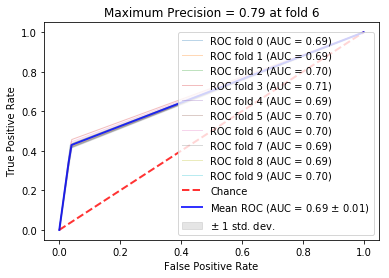

{'max_precision': 0.7934621099554234,
 'max_p_acc': 0.8347665847665847,
 'max_p_recall': 0.4442595673876872,
 'max_iteration': 6}

In [93]:
get_best_model_from_kf(knn1, k=10, threshold=.7)

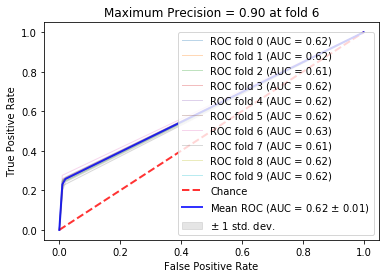

{'max_precision': 0.9021739130434783,
 'max_p_acc': 0.8144963144963145,
 'max_p_recall': 0.2762063227953411,
 'max_iteration': 6}

In [99]:
get_best_model_from_kf(knn1, k=10, threshold=.9)

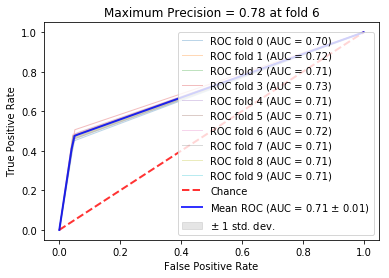

{'max_precision': 0.7788203753351206,
 'max_p_acc': 0.8390663390663391,
 'max_p_recall': 0.48336106489184694,
 'max_iteration': 6}

In [95]:
knn2 = KNeighborsClassifier(n_neighbors=7)
get_best_model_from_kf(knn2, k=10, threshold=.7)

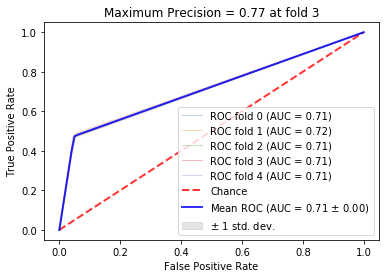

{'max_precision': 0.7667597765363129,
 'max_p_acc': 0.8385544635544635,
 'max_p_recall': 0.46903032891926527,
 'max_iteration': 3}

In [96]:
get_best_model_from_kf(knn2, k=5, threshold=.7)

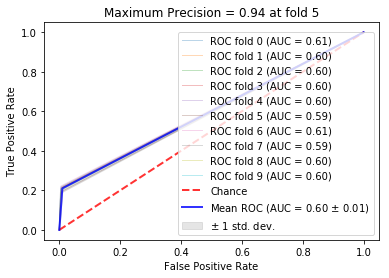

{'max_precision': 0.9414225941422594,
 'max_p_acc': 0.8007780507780508,
 'max_p_recall': 0.19003378378378377,
 'max_iteration': 5}

In [97]:
get_best_model_from_kf(knn2, k=10, threshold=.9)

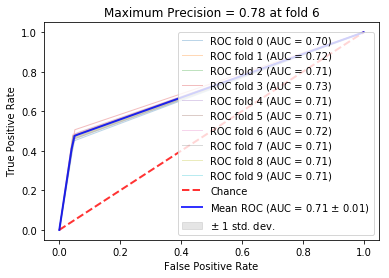

{'max_precision': 0.7788203753351206,
 'max_p_acc': 0.8390663390663391,
 'max_p_recall': 0.48336106489184694,
 'max_iteration': 6}

In [100]:
knn3 = KNeighborsClassifier(n_neighbors=9)
get_best_model_from_kf(knn2, k=10, threshold=.7)

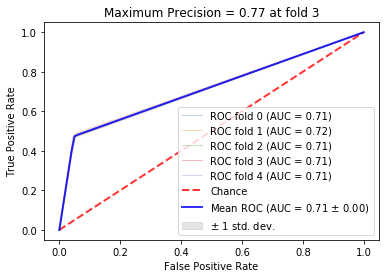

{'max_precision': 0.7667597765363129,
 'max_p_acc': 0.8385544635544635,
 'max_p_recall': 0.46903032891926527,
 'max_iteration': 3}

In [101]:
get_best_model_from_kf(knn2, k=5, threshold=.7)

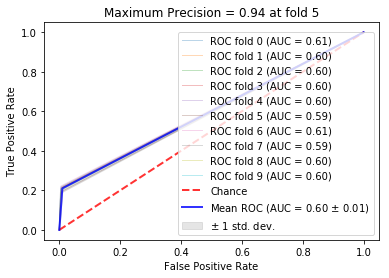

{'max_precision': 0.9414225941422594,
 'max_p_acc': 0.8007780507780508,
 'max_p_recall': 0.19003378378378377,
 'max_iteration': 5}

In [102]:
get_best_model_from_kf(knn2, k=10, threshold=.9)

LDA

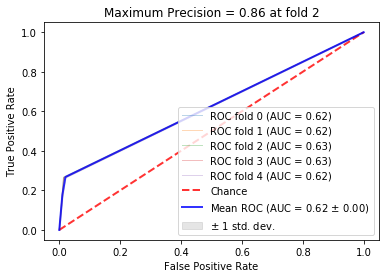

{'max_precision': 0.858887381275441,
 'max_p_acc': 0.8111179361179361,
 'max_p_recall': 0.2666385846672283,
 'max_iteration': 2}

In [104]:
lda_svd = LinearDiscriminantAnalysis(solver='svd')
get_best_model_from_kf(lda_svd, k=5, threshold=.7)

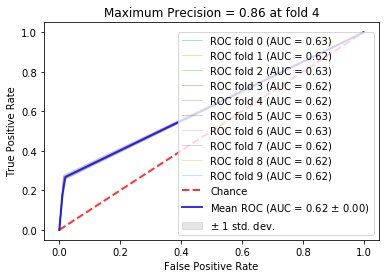

{'max_precision': 0.8647887323943662,
 'max_p_acc': 0.8093775593775594,
 'max_p_recall': 0.25798319327731095,
 'max_iteration': 4}

In [105]:
get_best_model_from_kf(lda_svd, k=10, threshold=.7)

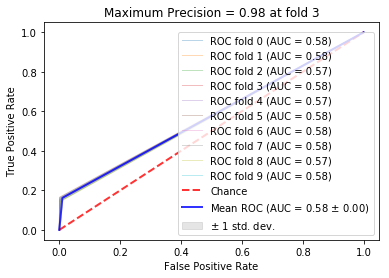

{'max_precision': 0.9796954314720813,
 'max_p_acc': 0.7995495495495496,
 'max_p_recall': 0.16523972602739725,
 'max_iteration': 3}

In [107]:
get_best_model_from_kf(lda_svd, k=10, threshold=.9)

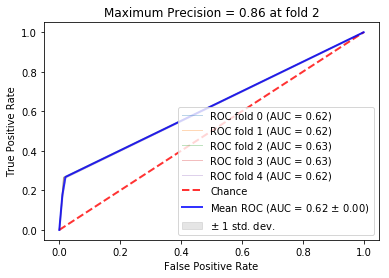

{'max_precision': 0.858887381275441,
 'max_p_acc': 0.8111179361179361,
 'max_p_recall': 0.2666385846672283,
 'max_iteration': 2}

In [108]:
lda_lsqr = LinearDiscriminantAnalysis(solver='lsqr')
get_best_model_from_kf(lda_lsqr, k=5, threshold=.7)

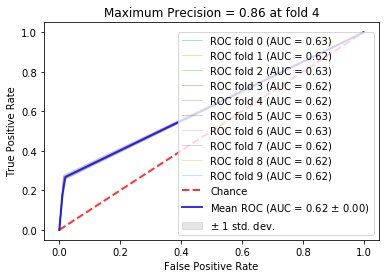

{'max_precision': 0.8647887323943662,
 'max_p_acc': 0.8093775593775594,
 'max_p_recall': 0.25798319327731095,
 'max_iteration': 4}

In [109]:
get_best_model_from_kf(lda_lsqr, k=10, threshold=.7)

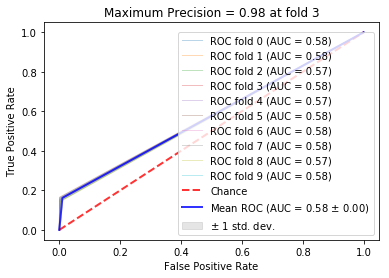

{'max_precision': 0.9796954314720813,
 'max_p_acc': 0.7995495495495496,
 'max_p_recall': 0.16523972602739725,
 'max_iteration': 3}

In [110]:
get_best_model_from_kf(lda_lsqr, k=10, threshold=.9)

Decision Tree

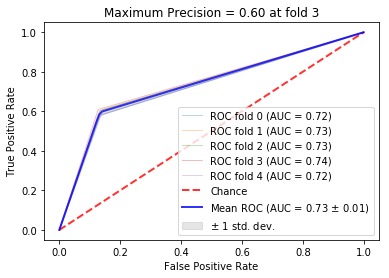

{'max_precision': 0.6006739679865206,
 'max_p_acc': 0.8092751842751843,
 'max_p_recall': 0.609141392567279,
 'max_iteration': 3}

In [117]:
dt_max_none = DecisionTreeClassifier(criterion='entropy')
get_best_model_from_kf(dt_max_none, k=5, threshold=.7)

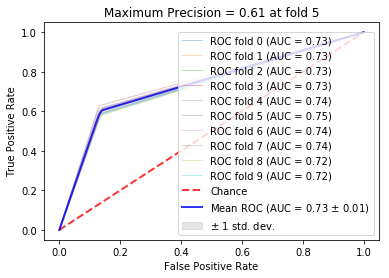

{'max_precision': 0.6053702196908055,
 'max_p_acc': 0.8106060606060606,
 'max_p_recall': 0.6283783783783784,
 'max_iteration': 5}

In [118]:
get_best_model_from_kf(dt_max_none, k=10, threshold=.7)

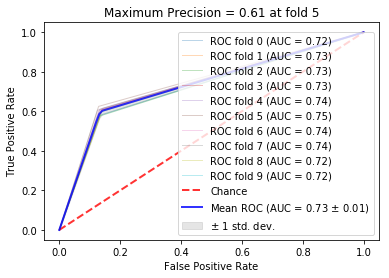

{'max_precision': 0.6075533661740559,
 'max_p_acc': 0.8112203112203112,
 'max_p_recall': 0.625,
 'max_iteration': 5}

In [120]:
get_best_model_from_kf(dt_max_none, k=10, threshold=.9)

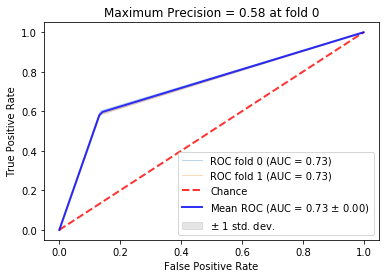

{'max_precision': 0.5840106153590977,
 'max_p_acc': 0.8018099176937882,
 'max_p_recall': 0.6015718434990603,
 'max_iteration': 0}

In [121]:
get_best_model_from_kf(dt_max_none, k=2, threshold=.9)

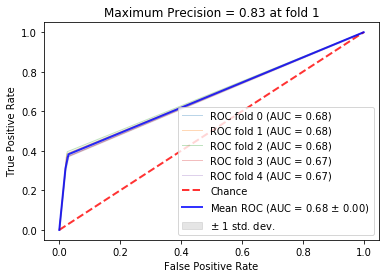

{'max_precision': 0.8342592592592593,
 'max_p_acc': 0.8342716757088751,
 'max_p_recall': 0.38487825715506196,
 'max_iteration': 1}

In [122]:
dt_max_10 = DecisionTreeClassifier(criterion='entropy', max_depth=10)
get_best_model_from_kf(dt_max_10, k=5, threshold=.7)

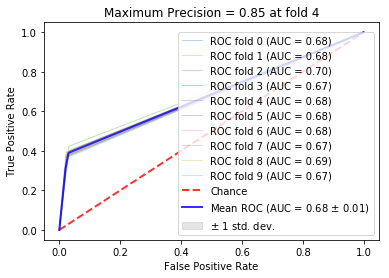

{'max_precision': 0.8519195612431444,
 'max_p_acc': 0.8351760851760852,
 'max_p_recall': 0.3915966386554622,
 'max_iteration': 4}

In [123]:
get_best_model_from_kf(dt_max_10, k=10, threshold=.7)

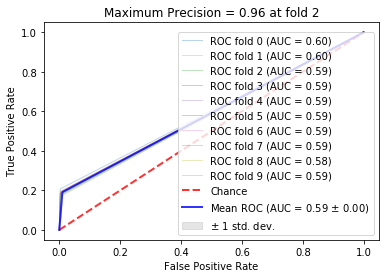

{'max_precision': 0.9557522123893806,
 'max_p_acc': 0.8022113022113022,
 'max_p_recall': 0.18430034129692832,
 'max_iteration': 2}

In [124]:
get_best_model_from_kf(dt_max_10, k=10, threshold=.9)

Random Forests

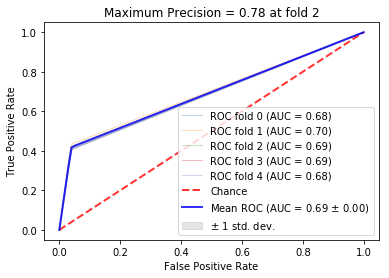

{'max_precision': 0.7831893165750197,
 'max_p_acc': 0.8307739557739557,
 'max_p_recall': 0.41996630160067394,
 'max_iteration': 2}

In [125]:
rf_10 = RandomForestClassifier(n_estimators=10, criterion='entropy')
get_best_model_from_kf(rf_10, k=5, threshold=.7)

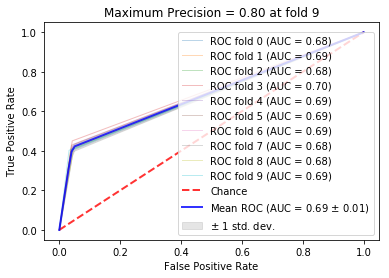

{'max_precision': 0.797274275979557,
 'max_p_acc': 0.8335380835380836,
 'max_p_recall': 0.4027538726333907,
 'max_iteration': 9}

In [126]:
get_best_model_from_kf(rf_10, k=10, threshold=.7)

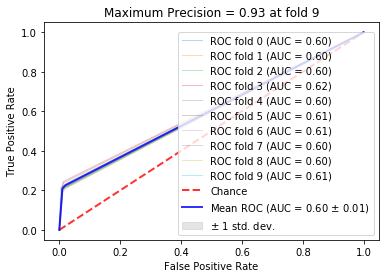

{'max_precision': 0.933579335793358,
 'max_p_acc': 0.8101965601965602,
 'max_p_recall': 0.21772805507745266,
 'max_iteration': 9}

In [127]:
get_best_model_from_kf(rf_10, k=10, threshold=.9)

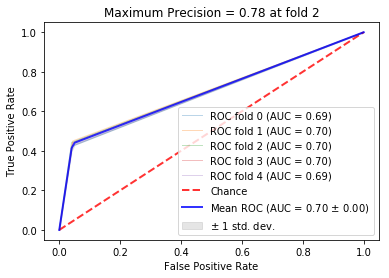

{'max_precision': 0.7785185185185185,
 'max_p_acc': 0.833947583947584,
 'max_p_recall': 0.44271272114574556,
 'max_iteration': 2}

In [128]:
rf_50 = RandomForestClassifier(n_estimators=50, criterion='entropy')
get_best_model_from_kf(rf_50, k=5, threshold=.7)

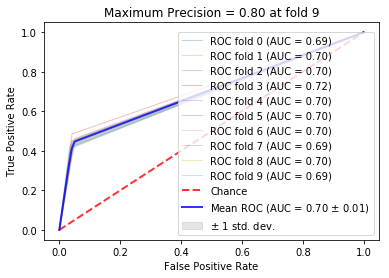

{'max_precision': 0.797077922077922,
 'max_p_acc': 0.8370188370188371,
 'max_p_recall': 0.4225473321858864,
 'max_iteration': 9}

In [133]:
get_best_model_from_kf(rf_50, k=10, threshold=.7)

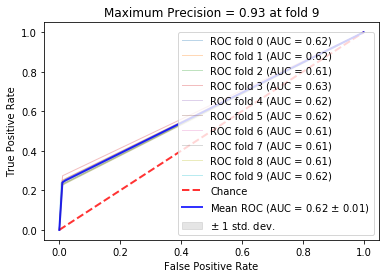

{'max_precision': 0.9324324324324325,
 'max_p_acc': 0.8144963144963145,
 'max_p_recall': 0.23752151462994836,
 'max_iteration': 9}

In [132]:
get_best_model_from_kf(rf_50, k=10, threshold=.9)

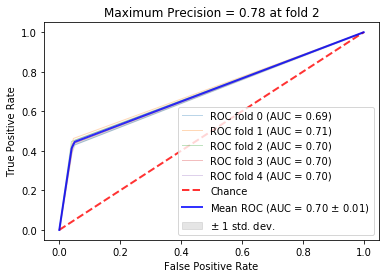

{'max_precision': 0.7820324005891016,
 'max_p_acc': 0.8353808353808354,
 'max_p_recall': 0.44734625105307496,
 'max_iteration': 2}

In [131]:
rf_100 = RandomForestClassifier(n_estimators=100, criterion='entropy')
get_best_model_from_kf(rf_100, k=5, threshold=.7)

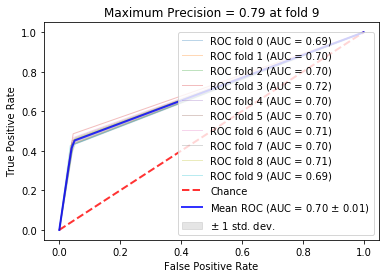

{'max_precision': 0.7869634340222575,
 'max_p_acc': 0.835995085995086,
 'max_p_recall': 0.4259896729776248,
 'max_iteration': 9}

In [134]:
get_best_model_from_kf(rf_100, k=10, threshold=.7)

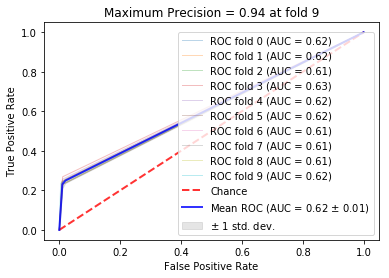

{'max_precision': 0.9415807560137457,
 'max_p_acc': 0.8147010647010647,
 'max_p_recall': 0.23580034423407917,
 'max_iteration': 9}

In [135]:
get_best_model_from_kf(rf_100, k=10, threshold=.9)